In [36]:
from dotenv import load_dotenv
from label_studio_sdk.client import LabelStudio
from glob import glob
from pathlib import Path
from sqlite3 import connect
from typing import Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn.linear_model
from scipy.ndimage import map_coordinates
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go


In [2]:
%matplotlib widget

In [3]:
load_dotenv()

True

In [4]:
LABEL_STUDIO_URL = "https://labeler.e4e.ucsd.edu"
LABEL_STUDIO_API_KEY = os.environ["LABEL_STUDIO_API_KEY"]
LABEL_STUDIO_PROJECT_ID = 46

LABEL_STUDIO_URL, LABEL_STUDIO_API_KEY, LABEL_STUDIO_PROJECT_ID

('https://labeler.e4e.ucsd.edu',
 '81c03c9417007e80fad61214587317d08d306a3d',
 46)

In [5]:
ipad_camera_intrinsics = np.array([[1604.2147, 0.0, 956.5816],
                                   [0.0, 1604.2147, 717.7617],
                                   [0.0, 0.0, 1.0]])
iphone_camera_intrinsics = np.array([[1375.0719, 0.0, 968.6433],
                                     [0.0, 1375.0719, 723.04926],
                                     [0.0, 0.0, 1.0]])

In [6]:
label_studio = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=LABEL_STUDIO_API_KEY)

label_studio

In [7]:
# path containing 2025.06.27.FishSense.SanDiego
PATH_TO_DATA = Path(os.environ["PATH_TO_DATA"])

In [8]:
# rgbs = [Path(g).absolute().resolve() for g in glob("../data/2025.06.27.FishSense.SanDiego/**/**/FSM/rgb_*.jpg", recursive=True)]
rgbs = [(PATH_TO_DATA / Path(g)).resolve() for g in glob("2025.06.27.FishSense.SanDiego/**/**/FSM/rgb_*.jpg", root_dir=PATH_TO_DATA, recursive=True)]
timestamp_to_rgb_map = {int(f.stem[4:]):f for f in rgbs}

rgbs

[PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059596.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059200.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059821.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059518.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751047797.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751048739.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751061242.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751047800.jpg'),
 PosixPath('/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751047788.jpg'),
 PosixPath('/Volume

In [9]:
def get_depth_map_and_confidence_map(timestamp: int, database_path: Path) -> Tuple[np.ndarray[float], np.ndarray[int]]:
    with connect(database_path) as connection:
        cursor = connection.cursor()

        query = """
        SELECT depth_bytes, depth_width, depth_height, confidence_bytes, confidence_width, confidence_height FROM photos
        WHERE utc_unix_timestamp = ?"""

        cursor.execute(query, (timestamp,))
        row = cursor.fetchone()

        depth_width = row[1]
        depth_height = row[2]
        depth_map = np.frombuffer(row[0], dtype=np.float32).reshape((depth_height, depth_width))

        confidence_width = row[4]
        confidence_height = row[5]
        confidence_map = np.frombuffer(row[3], dtype=np.int8).reshape((confidence_height, confidence_width))

    return depth_map, confidence_map

In [104]:
def plane_ransac(depth_array):
    """
    Perform RANSAC to fit a plane to the depth data.
    Returns the coefficients of the plane equation Ax + By + C = z.
    Code written with Copilot help.
    """
    # Flatten the depth array and get valid points
    # valid_points = np.argwhere(depth_array > 0)
    # if len(valid_points) < 3:
    #     return 0, 0, 1  # Not enough points to fit a plane

    # # Fit a plane using RANSAC
    from sklearn.linear_model import RANSACRegressor, LinearRegression

    # X = valid_points[:, 1].reshape(-1, 1)  # x-coordinates
    # Y = valid_points[:, 0].reshape(-1, 1)  # y-coordinates
    # Z = depth_array[valid_points[:, 0], valid_points[:, 1]].reshape(-1, 1)  # z-coordinates
    
    
    XY = depth_array[0:2,:].T
    Z = depth_array[2,:]
    
    model = RANSACRegressor(LinearRegression(), min_samples=3)
    model.fit(XY, Z)
    

    return model.estimator_.coef_[0], model.estimator_.coef_[1], model.estimator_.intercept_
    
    model = LinearRegression()
    model.fit(XY, Z)
    return model.coef_[1], model.coef_[0], model.intercept_

In [105]:
norm_vec = plane_ransac(ransac_points)

In [102]:
for task in label_studio.tasks.list(project=LABEL_STUDIO_PROJECT_ID):
    timestamp = int(Path(task.storage_filename).stem[4:])
    if timestamp not in timestamp_to_rgb_map:
        continue

    if not any(a["result"] for a in task.annotations):
        continue

    rgb_path = timestamp_to_rgb_map[timestamp]
    database_path = rgb_path.parent / "database.sqlite"
    
    print(rgb_path)

    rgb_image = cv2.imread(rgb_path)
    depth_map, confidence_map = get_depth_map_and_confidence_map(timestamp, database_path)

    snout = [r for a in task.annotations for r in a["result"] if any(k == "Snout" for k in r["value"]["keypointlabels"])][0]
    fork = [r for a in task.annotations for r in a["result"] if any(k == "Fork" for k in r["value"]["keypointlabels"])][0]

    snout = [snout["value"]["x"] / 100, snout["value"]["y"] / 100]
    fork = [fork["value"]["x"] / 100, fork["value"]["y"] / 100]

    annotations = np.array([snout, fork])
    rgb_height, rgb_width, _ = rgb_image.shape
    rgb_shape = np.array([rgb_width, rgb_height])
    rgb_annotations = annotations * rgb_shape

    depth_height, depth_width = depth_map.shape
    depth_map_shape = np.array([depth_width, depth_height])
    depth_annotations = annotations * depth_map_shape

    camera_intrinsics = ipad_camera_intrinsics if "iPad" in str(rgb_path) else iphone_camera_intrinsics

    depths = depth_map[depth_annotations[:, 1].astype(int), depth_annotations[:, 0].astype(int)]

    points3d = np.linalg.inv(camera_intrinsics) @ np.array([rgb_annotations[:, 0], rgb_annotations[:, 1], np.ones_like(rgb_annotations[:, 0])])
    for idx, depth_pixel in enumerate(depths):
        points3d[:, idx] *= depth_pixel
        
    fish_length = np.linalg.norm(points3d[:, 0] - points3d[:, 1])
    
    ransac_mesh = np.meshgrid(np.arange(rgb_width), np.arange(rgb_height))
    
    ransac_points = np.linalg.inv(camera_intrinsics) @ np.array([ransac_mesh[0].ravel(), ransac_mesh[1].ravel(), np.ones(rgb_width*rgb_height)])
    
    rgb_points = np.stack((ransac_mesh[1].ravel(), ransac_mesh[0].ravel()), axis=1)
    
    percent_points = (rgb_points * 1.0) / ((np.array([rgb_height, rgb_width]) - 1) * 1.0)
    
    depth_points = np.floor(percent_points * (np.array([depth_height, depth_width]) - 1)).astype(int)
    depths = depth_map[depth_points[:, 0], depth_points[:, 1]]
    
    ransac_points = np.repeat(depths[:, None], 3, axis=1).T * ransac_points

    
    
    
    print(ransac_points.shape)
    
    
    norm_vec = plane_ransac(ransac_points)
    
    print(norm_vec)
    ransac_angle = np.arccos(np.dot(norm_vec, np.array([0, 0, 1]))/(np.linalg.norm(norm_vec)))
    
    print(np.degrees(ransac_angle))
    
    
    break

/Volumes/fishsense_data/CCFRP/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751040799.jpg
(3, 2764800)
[[-0.45362505 -0.34037315]
 [-0.45315084 -0.34037315]
 [-0.45267662 -0.34037315]
 ...
 [ 0.2442387   0.18341413]
 [ 0.24449301  0.18341413]
 [ 0.2434291   0.18242626]]
(np.float64(-0.4932582314860193), np.float64(-0.2329619576606368), np.float64(0.5301297619485797))
45.818900204202706


In [109]:
import random, pandas as pd, statsmodels.api as sm

point_args = random.sample(range(rgb_height * rgb_width), 100000)

xM, yM, zM = 0, 0, 0
vx, vy, vz = norm_vec

# Create a meshgrid for x and y
x_vals = np.linspace(ransac_points[0,:].min(), ransac_points[0,:].max(), 50)
y_vals = np.linspace(ransac_points[1,:].min(), ransac_points[1,:].max(), 50)
X, Y = np.meshgrid(x_vals, y_vals)

# Calculate Z based on the plane equation
# Handle cases where a normal vector component is zero
Z = (vx*X) + (vy*Y) + vz




# Regression plane
plane = go.Surface(x=X, y=Y, z=Z, colorscale='Blues', showscale=False)

scatter = go.Scatter3d(
        x=ransac_points[0, point_args],
        y=ransac_points[1, point_args],
        z=ransac_points[2, point_args],
        mode='markers',
        marker=dict(size=1, color=rgb_image[rgb_points[point_args, 0], rgb_points[point_args, 1], ::-1].astype(float) / 255.0),
        name='Data Points'
    )

fig = go.Figure(data=[scatter, plane])
fig.show()


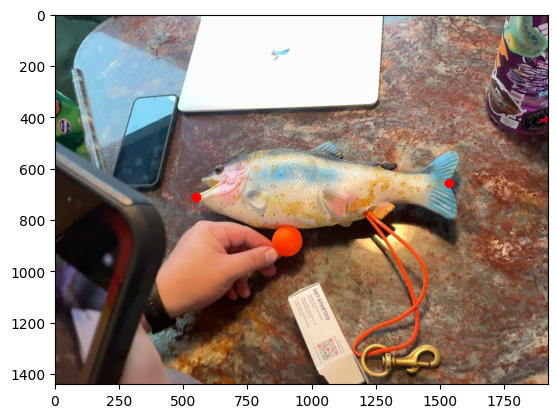

In [ ]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.plot(rgb_annotations[:, 0], rgb_annotations[:, 1], 'ro')

In [ ]:
depth_map

array([[0.5126953 , 0.49267578, 0.48535156, ..., 0.3864746 , 0.3815918 ,
        0.40942383],
       [0.48657227, 0.47851562, 0.48291016, ..., 0.38842773, 0.390625  ,
        0.40063477],
       [0.48120117, 0.4777832 , 0.47924805, ..., 0.38891602, 0.39086914,
        0.3881836 ],
       ...,
       [0.37890625, 0.38354492, 0.3815918 , ..., 0.3984375 , 0.39916992,
        0.3972168 ],
       [0.38256836, 0.37548828, 0.3815918 , ..., 0.39868164, 0.40283203,
        0.39892578],
       [0.38085938, 0.38208008, 0.38012695, ..., 0.3972168 , 0.3996582 ,
        0.39672852]], shape=(192, 256), dtype=float32)

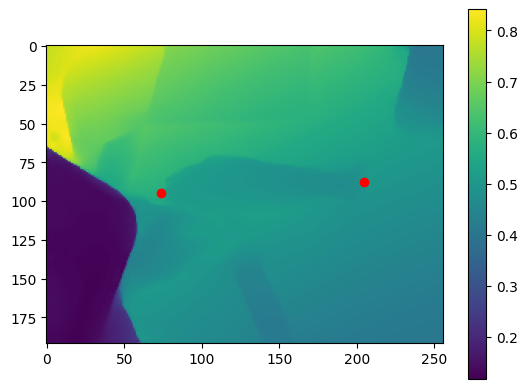

In [ ]:
plt.imshow(depth_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

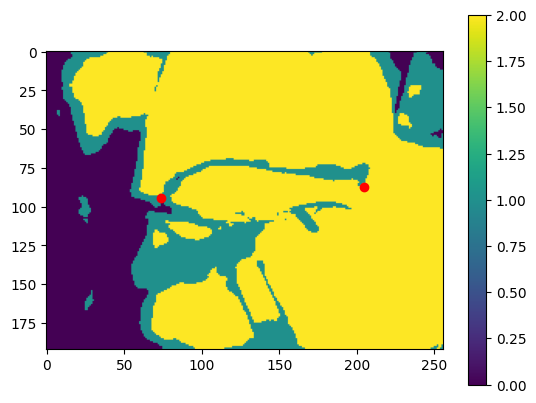

In [ ]:
plt.imshow(confidence_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()